In [9]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

import matplotlib.pyplot as plt
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pickle

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Record Audio

In [11]:
def feature_extractor(sound_path, win_length_ms=25, hop_length_ms=10):
    # Load the audio file
    signal, sr = librosa.load(sound_path,sr=8000)
    # signal,sr = wavfile.read(sound_path)
    # Extract MFCCs
    win_length_samples = int(sr * win_length_ms / 1000)
    hop_length_samples = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length_samples, win_length=win_length_samples)
    # mfccs = mfcc(signal,samplerate=sr,nfft = 2048,numcep=13,nfilt=13)
    
    #Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [12]:
def preprocess(path, is_pca=0, num_pca = 2, window_length_ms=20, hop_length_ms=10):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=8000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    # samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file,window_length_ms,hop_length_ms)
    # tot= np.concatenate((a,b,c,d)).T
    tot = d.T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [13]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50,window_length_ms=20, hop_length_ms=10):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            # samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            # samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            # tot = np.concatenate((a, b, c, d)).T
            tot = d.T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

# Histogram plot to show that its mixture of gaussians

# Main Code

In [14]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

In [15]:
train_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Train","../Dataset/Language-Recognition-VADaudio/Tamil-Train","../Dataset/Language-Recognition-VADaudio/Telugu-Train"]
test_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Test","../Dataset/Language-Recognition-VADaudio/Tamil-Test","../Dataset/Language-Recognition-VADaudio/Telugu-Test"]

In [16]:
import math
from scipy.stats import multivariate_normal
import numpy as np


In [17]:
class GMMNew:
    def __init__(
        self, 
        n_mixtures=120, 
        max_iter=100, 
        covar_type='full', 
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.log_likelihood_plot_list = None
        

    def p(self, data, mean, cov):
        dist = multivariate_normal(mean=mean, cov=cov,allow_singular=True)
        return dist.pdf(data)
    
    
    def get_score(self,data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        return np.mean(np.log(resp.sum(axis=1)))
    
    # Function to get the log likelihood
    def get_loglikelihood(self,data):
        return self.get_score(data)
    
    def aic_bic(self, data):
        # Get the log-likelihood
        log_likelihood = self.get_loglikelihood(data)
        
        # Calculate the number of parameters in the model
        n_params = self.n_mixtures
        
        # Calculate AIC and BIC
        aic = -2 * log_likelihood*data.shape[0] + 2 * n_params
        bic = -2 * log_likelihood*data.shape[0] + n_params * np.log(len(data))
        
        return aic, bic
    
    def full_covar(self, data, resp):
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = data - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i].flat[::data.shape[1] + 1] += 1e-6
        return new_covs
            
    def diag_covar(self, data, resp):
        n_features = data.shape[1]
        new_covs = np.zeros((self.n_mixtures, n_features, n_features))
        wik = resp[:,i]
        for i in range(self.n_mixtures):
            num = wik.reshape(data.shape[0],1)*np.square(data-self.means[i])
            column_sums = np.sum(num,axis=0) # result will be (1,d) matrix
            assert(column_sums.shape==(1,data.shape[1]))
            column_sums /= np.sum(wik)
            new_covs[i] = np.diag(column_sums+1e-6) # regularisation term
        return new_covs
    
    def e_step(self, data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        # normalize the sum
        resp = resp / resp.sum(axis=1)[:, None]
        return resp
    
    def m_step(self, data, resp):        
        # re-estimation for alphas
        new_alphas = resp.mean(axis=0)
        
        # re-estimation for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i][:, None], data).sum(axis=0) / resp[:, i].sum()
        
        # re-estimation for covariance matrix
        if self.covar_type == 'full':
            new_covs = self.full_covar(data, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(data, resp)
            
        return new_alphas, new_means, new_covs
    
        
    def fit(self, data):
        n_features = data.shape[1]
        last = 0
        # intialize empty lists to store images and 
        self.log_likelihood_plot_list = []
        
        # initialize means
        kmeans_model =  KMeans(self.n_mixtures).fit(data)
        self.means = kmeans_model.cluster_centers_
        
        # initialize cov
        self.covs = np.zeros((self.n_mixtures, n_features, n_features))
        data_labels = kmeans_model.labels_
    
        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(data[data_labels == i].T+0.1)
        
        # EM - algorithm
        for step in range(self.max_iter):
            last = step
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(data)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(data, resp)
            
            
            # Check for convergence criteria
            if np.allclose(self.alphas, alphas, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.means, means, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.covs, covs, rtol=1e-4, atol=1e-4):
                print("Converged at",step)
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]

        # plt.plot(range(last), self.log_likelihood_plot_list,color='g', linewidth=2)
        # plt.xlabel('Number of Iteration')
        # plt.ylabel('Log Likelihood')
        # plt.title('Variation of Log Likelihood for each iteration')
        # plt.tight_layout()  
        # plt.show()
        

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score

def pipeline(n_components_gmm,is_pca,num_pca):
    gmms = []
    i = 0
    for path in train_paths:
        i += 1
        X = preprocess_folder(path,is_pca,num_pca,items=110)
        gmm = GMMNew(n_components_gmm,100,'full')
        gmm.fit(data=X)
        with open(f'gmm_{n_components_gmm}_{num_pca}_{i}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        gmms.append(gmm)
        
        print(f"{path} is done")
        aic, bic = gmm.aic_bic(X)
        print(f"Model {i} AIC: {aic}, BIC: {bic}")
        

    # Initialize confusion matrix
    confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

    for idx, path in enumerate(test_paths):
        # Initialize counters for each class
        class_counts = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file,is_pca,num_pca)
                log_likelihood = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm    = gmms[i]  #checking with each model one by one
                    log_likelihood[i] = gmm.get_score(vector)
            
                winner = np.argmax(log_likelihood)
                class_counts[winner] += 1  # Increment the count for the winner class

        # Update confusion matrix
        for true_label, count in class_counts.items():
            confusion_matrix[idx, true_label] = count

    # Iterate through each data point in X and assign cluster labels
    cluster_labels_list = []
    for x in X:
        log_likelihood = [gmm.get_score(x) for gmm in gmms]  # Calculate log-likelihood for each GMM
        predicted_cluster = np.argmax(log_likelihood)  # Assign to cluster with maximum log-likelihood
        cluster_labels_list.append(predicted_cluster)

    # Convert cluster labels to numpy array
    cluster_labels = np.array(cluster_labels_list)

    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Print the silhouette score
    print("Silhouette Score:", silhouette_avg)

    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")

## Plotting Graphs - Confusion Matrix

Num comp:32, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 52685.0179850026, BIC: 284630.9901113155
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 52677.678705334445, BIC: 286289.43505825504
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52681.22949998871, BIC: 280423.56904102245
Silhouette Score: 0.003256896


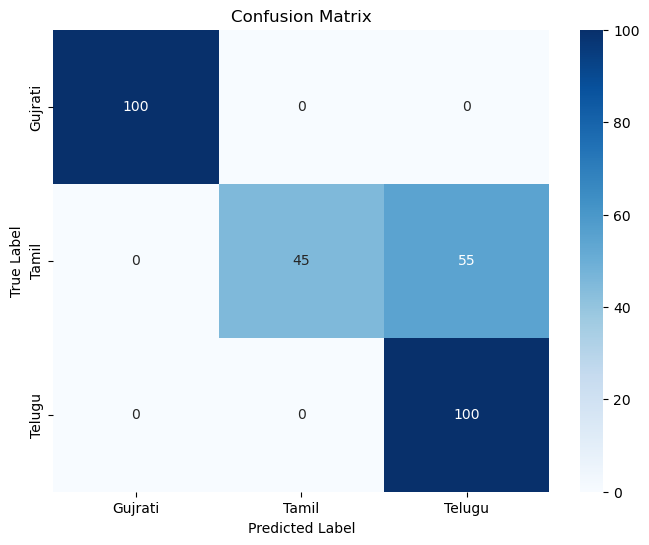

Overall Accuracy: 81.67%
Num comp:64, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 105161.37876189791, BIC: 569053.3230145237
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 105153.48407816343, BIC: 572376.9967840046
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 105158.19044631787, BIC: 560642.8695283853
Silhouette Score: -0.010891462


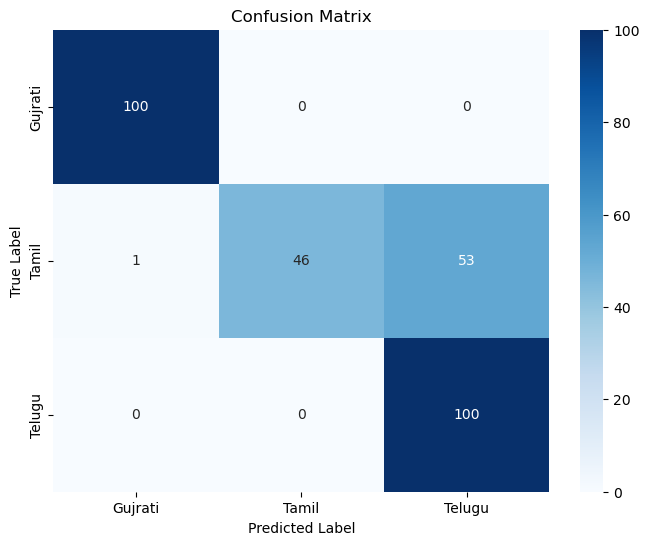

Overall Accuracy: 82.00%


In [27]:
import warnings
warnings.filterwarnings("ignore")

n_comp_list = [32,64]
num_pca_list = [39]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand)

# Testing

In [14]:
def pipeline_full(n_components_gmm,is_pca,num_pca):
    gmms = []

    for path in train_paths:
        X = preprocess_folder(path,is_pca,num_pca,items=240)
        gmm = GMMNew(n_components_gmm,100,'full')
        gmm.fit(data=X)
        gmms.append(gmm)
        with open(f'gmmfull_{n_components_gmm}_{num_pca}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        print(f"{path} is done")

    # Initialize confusion matrix
    confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

    for idx, path in enumerate(test_paths):
        # Initialize counters for each class
        class_counts = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file,is_pca,num_pca)
                log_likelihood = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm    = gmms[i]  #checking with each model one by one
                    log_likelihood[i] = gmm.get_score(vector)
            
                winner = np.argmax(log_likelihood)
                class_counts[winner] += 1  # Increment the count for the winner class

        # Update confusion matrix
        for true_label, count in class_counts.items():
            confusion_matrix[idx, true_label] = count

    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")

Num comp:32, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done


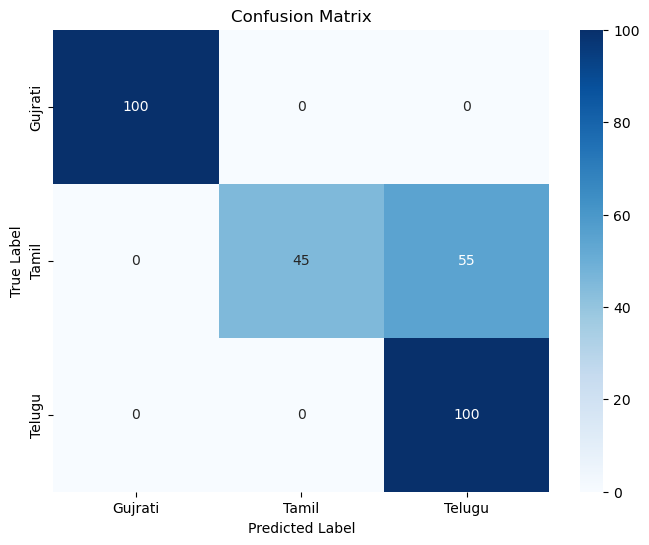

Overall Accuracy: 81.67%
Num comp:64, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done


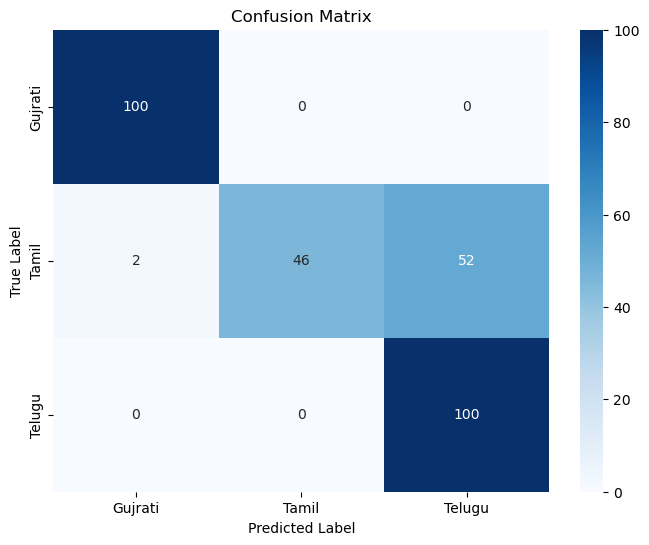

Overall Accuracy: 82.00%
Num comp:120, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done


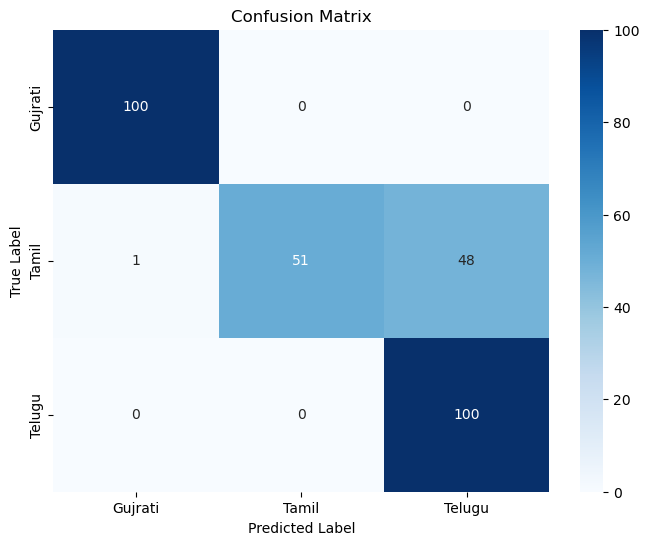

Overall Accuracy: 83.67%
Num comp:256, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done


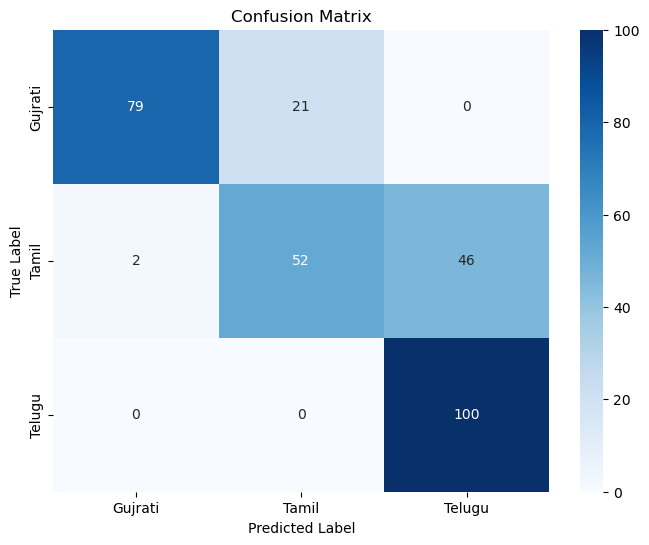

Overall Accuracy: 77.00%
Num comp:512, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done


In [16]:
n_comp_list = [32,64,120,256,512]
num_pca_list = [39,24,13,6]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand)